# Random Forest Classification of protein-kinase cancer links

This notebook takes as input the data on Clinical Trials (according to year and phase) and embedded vectors that represent words and concepts in PubMed. It uses data collected up to a certain year (refered to as target year in the code, e.g., 2010), uses this data to train a Random Forest model, and assess how well the model predicts protein kinase - cancer links in future years. See the manuscript for details on the methods. 

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, precision_score, recall_score, average_precision_score, confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sys.path.insert(0, os.path.abspath('..'))
from kcet import KcetDatasetGenerator, KcetRandomForest

## Obtaining the input data
The concept vectors are available from a zenodo repository: https://zenodo.org/record/5329035 Download the five files to a local directory and enter the path of this directory in the following input dialog

- embedding_SG_dim100_upto2010.npy
- embedding_SG_dim100_upto2020.npy
- words_SG_upto2010.txt
- words_SG_upto2020.txt
- clinical_trials_by_phase.tsv


To run this notebook, download all of these files to the same directory and enter the path to the directory after running the ``input()`` command.

In [2]:
download_dir = input()

 /home/peter/data/pubmed2vec


In [3]:
ctfile = os.path.join(download_dir, "clinical_trials_by_phase.tsv")
embeddings = os.path.join(download_dir, "embedding_SG_dim100_upto2010.npy")
words =  os.path.join(download_dir, "words_SG_upto2010.txt")
if not os.path.isfile(ctfile):
    raise FileNotFoundError("Could not find clinical trials file at %s" % ctfile)
if not os.path.isfile(embeddings):
    raise FileNotFoundError("Could not find 2010 embeddings file at %s" % embeddings)
if not os.path.isfile(words):
    raise FileNotFoundError("Could not find 2010 words file at %s" % words)    

### Display receiver operating characteristics (ROC) curve
The following function adds a single ROC curve to a matplotlib axis object.

In [4]:
def plot_one_auc_curve(axis, y_test, yproba, begin_year: int, end_year: int, n_pos_test):
    fpr, tpr, thresholds_auc = roc_curve(y_test,  yproba)
    auc_roc = roc_auc_score(y_test, yproba)
    axis.plot(fpr, tpr, label='%d-%d (%0.2f), n=%d' %(begin_year, end_year, auc_roc, n_pos_test))
    return auc_roc

### Display precision recall (PR) curve
The following function adds a single PR curve to a matplotlib axis object. 

In [5]:
def plot_one_precision_recall_curve(axis, y_test, y_pred, begin_year: int, end_year: int, n_pos_test):
    """
    Plot a single precision recall curve
    axis: a matplotlib axis
    y_test: a numpy.ndarray with known classes
    y_pred: a numpy.ndarray with predictions
    midyear: an integer -- the start year for our predictions
    num_years_later: an integer -- how many years after midyear to go
    n_pos_test: number of true examples that are positive
    """
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    fscore = (2 * precision * recall) / (precision + recall)

    auc_recall_precision = average_precision_score(y_test, y_pred)
    
    my_label = '%d-%d, (%0.2f), n=%d' % (begin_year, end_year, auc_recall_precision, n_pos_test)
    axis.plot(recall, precision, label=my_label)
    f1_scores = 2*recall*precision/(recall+precision)
    # some nan values are encountered. The following replaces NaN by 0.0
    f1_scores = np.nan_to_num(f1_scores)
    best_threshold =  thresholds[np.argmax(f1_scores)]
    best_f1 = np.max(f1_scores)
    precision_at_threshold = precision_score(y_test, y_pred > best_threshold)
    recall_at_threshold = recall_score(y_test, y_pred > best_threshold)
    return best_threshold, best_f1, precision_at_threshold, recall_at_threshold

## KcetDatasetGenerator
The KcetDatasetGenerator class ingests and integrates all of the datasources used for Random Forest classification. 
Note that ``targetyear`` should match the latest year included in the training/validation dataset (in this case, we use 2010 since we derived embeddings from PubMed up to 2010 and test against PK/Cancer data from 2011 and onwards).

In [6]:
datagen = KcetDatasetGenerator(clinical_trials=ctfile, embeddings=embeddings, words=words)

Iterations: .....

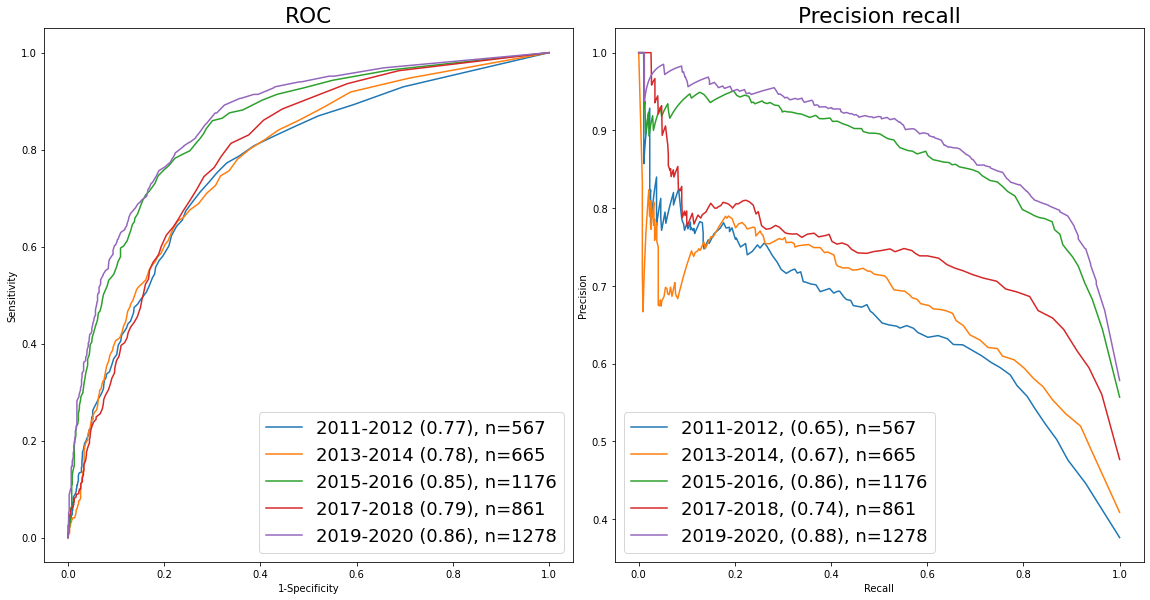

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
fig.tight_layout()
font = {'family' :'normal', 'size': 18}
matplotlib.rc('font', **font)

targetyear = 2010
prediction_years= [(2011,2012), (2013,2014), (2015,2016), (2017,2018), (2019,2020)]

krf = KcetRandomForest(data_gen=datagen, target=targetyear, embedddingfile=embeddings, wordsfile=words)

pr_data = []

print("Iterations: ", end='')
for (begin_y, end_y) in prediction_years:
    print(".", end = '')
    y_pred, y_test, yproba, n_pos_test = krf.classify(begin_year=begin_y, end_year=end_y)
    # print(metrics.confusion_matrix(y_test,y_pred))
    auc_roc = plot_one_auc_curve(ax1, y_test, yproba, begin_y, end_y, n_pos_test)
    thresh, fscore, precision_at_threshold, recall_at_threshold = plot_one_precision_recall_curve(ax2, y_test, yproba, begin_y, end_y, n_pos_test)
    pr_data.append({"start": begin_y, 
                    "end": end_y,
                    "AUROC": auc_roc,
                    "threshold": thresh, 
                    "f-score": fscore, 
                    "precision@threshold": precision_at_threshold, 
                    "recall@threshold": recall_at_threshold,
                    "n_pos_test": n_pos_test})
# show this below with results for P/R analysis
pr_df = pd.DataFrame(pr_data)
    
     
ax1.set_title('ROC');
ax1.set_xlabel('1-Specificity');
ax1.set_ylabel('Sensitivity');
ax1.legend(loc="lower right");
ax2.set_title('Precision recall');
ax2.set_xlabel('Recall');
ax2.set_ylabel('Precision');
ax2.legend(loc="lower left");   

# Summary
The threshold refers to the threshold probability at which the highest F1 score was obtained for the precision recall analysis. 
The remaining two columns show the precision and recall at these thresholds.
The analysis was performed for different combinations of years following the target year of 2010.

In [8]:
pr_df

,start,end,AUROC,threshold,f-score,precision@threshold,recall@threshold,n_pos_test
0,2011,2012,0.769621,0.040,0.666160,0.594972,0.751323,567
1,2013,2014,0.776894,0.035,0.682458,0.604895,0.780451,665
2,2015,2016,0.849674,0.050,0.819287,0.786677,0.843537,1176
3,2017,2018,0.789972,0.025,0.746224,0.668224,0.830430,861
4,2019,2020,0.862313,0.035,0.837927,0.795309,0.875587,1278


# Adjusting the n_pk parameter

In many cases, the PKIs inhibit multiple PKs at a < 0.3μM cutoff, and a total of 84 PKs are inhibited by these kinases. The mean number of PKs inhibited by a given PKI was 2.8 (median 2, min. 1, max. 5), and the mean number of PKIs that inhibit a given PK was 2.5 (median 2, min. 1, max. 13) 

We tested the method using a cutoff of assigning 1, 2, 5, and 10 PKs to each PKI (only if the PKs satisfied the < 0.3μM cutoff).

This can be adjusted using the n_pk parameter of ``KcetRandomForest`` (default 5) as follows (here we use 2).

Iterations: .....

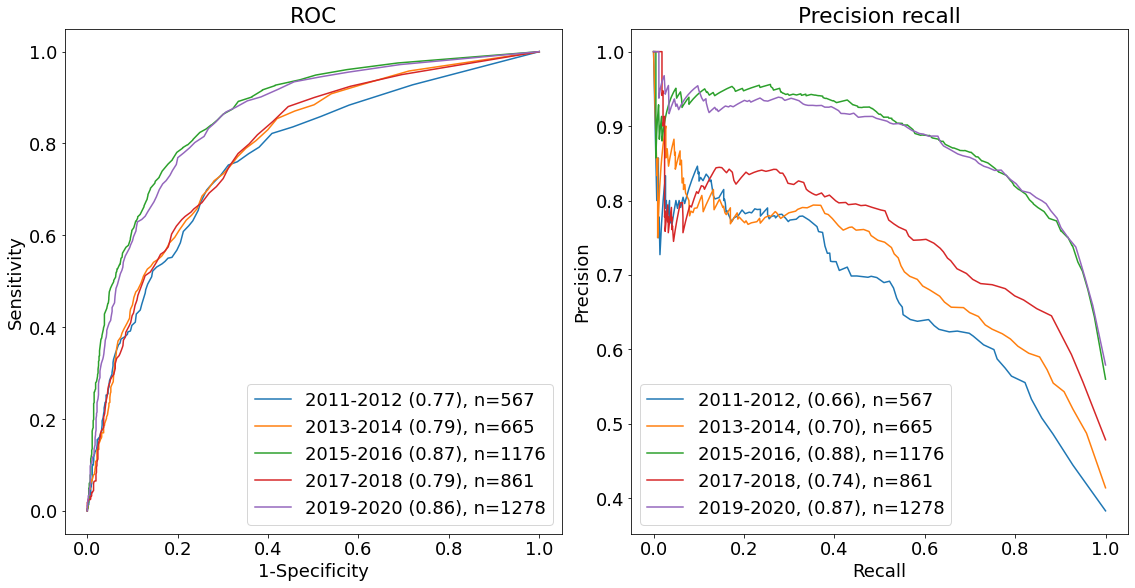

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
fig.tight_layout()
font = {'family' :'normal', 'size': 18}
matplotlib.rc('font', **font)

targetyear = 2010
prediction_years= [(2011,2012), (2013,2014), (2015,2016), (2017,2018), (2019,2020)]

datagen = KcetDatasetGenerator(clinical_trials=ctfile, embeddings=embeddings, words=words, n_pk=2)
krf = KcetRandomForest(data_gen=datagen, target=targetyear, embedddingfile=embeddings, wordsfile=words)

pr_data = []

print("Iterations: ", end='')
for (begin_y, end_y) in prediction_years:
    print(".", end = '')
    y_pred, y_test, yproba, n_pos_test = krf.classify(begin_year=begin_y, end_year=end_y)
    # print(metrics.confusion_matrix(y_test,y_pred))
    auc_roc = plot_one_auc_curve(ax1, y_test, yproba, begin_y, end_y, n_pos_test)
    thresh, fscore, precision_at_threshold, recall_at_threshold = plot_one_precision_recall_curve(ax2, y_test, yproba, begin_y, end_y, n_pos_test)
    pr_data.append({"start": begin_y, 
                    "end": end_y,
                    "AUROC": auc_roc,
                    "threshold": thresh, 
                    "f-score": fscore, 
                    "precision@threshold": precision_at_threshold, 
                    "recall@threshold": recall_at_threshold,
                    "n_pos_test": n_pos_test})
# show this below with results for P/R analysis
pr_df = pd.DataFrame(pr_data)
    
     
ax1.set_title('ROC');
ax1.set_xlabel('1-Specificity');
ax1.set_ylabel('Sensitivity');
ax1.legend(loc="lower right");
ax2.set_title('Precision recall');
ax2.set_xlabel('Recall');
ax2.set_ylabel('Precision');
ax2.legend(loc="lower left");   

In [11]:
pr_df

,start,end,AUROC,threshold,f-score,precision@threshold,recall@threshold,n_pos_test
0,2011,2012,0.771033,0.055238,0.656452,0.604478,0.714286,567
1,2013,2014,0.810272,0.035000,0.719528,0.650000,0.801504,665
2,2015,2016,0.862819,0.050000,0.821155,0.791634,0.852891,1176
3,2017,2018,0.797510,0.025000,0.746867,0.664540,0.846690,861
4,2019,2020,0.865723,0.040000,0.829678,0.783404,0.871674,1278


# ROC and PR analysis for Phase 4 data
We only need to set the phase4 parameter in the KcetRandomForest method ``classify`` to True.

Iterations: .....

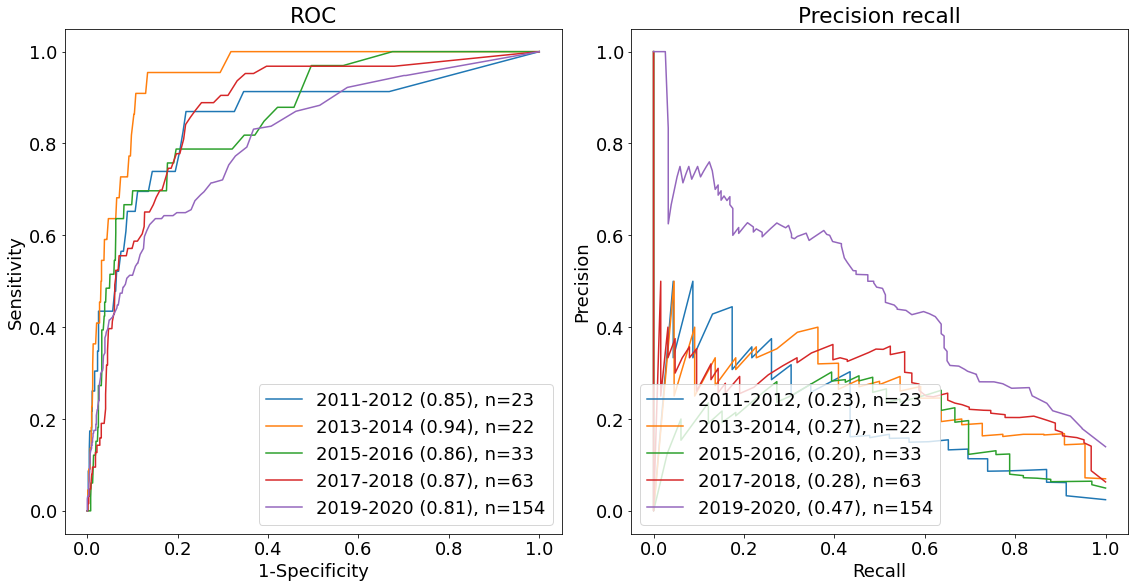

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
fig.tight_layout()
font = {'family' :'normal', 'size': 18}
matplotlib.rc('font', **font)

targetyear = 2010
prediction_years= [(2011,2012), (2013,2014), (2015,2016), (2017,2018), (2019,2020)]

datagen = KcetDatasetGenerator(clinical_trials=ctfile, embeddings=embeddings, words=words, n_pk=2)
krf = KcetRandomForest(data_gen=datagen, target=targetyear, embedddingfile=embeddings, wordsfile=words)

pr_data = []

print("Iterations: ", end='')
for (begin_y, end_y) in prediction_years:
    print(".", end = '')
    y_pred, y_test, yproba, n_pos_test = krf.classify(begin_year=begin_y, end_year=end_y, phase4=True)
    # print(metrics.confusion_matrix(y_test,y_pred))
    auc_roc = plot_one_auc_curve(ax1, y_test, yproba, begin_y, end_y, n_pos_test)
    thresh, fscore, precision_at_threshold, recall_at_threshold = plot_one_precision_recall_curve(ax2, y_test, yproba, begin_y, end_y, n_pos_test)
    pr_data.append({"start": begin_y, 
                    "end": end_y,
                    "AUROC": auc_roc,
                    "threshold": thresh, 
                    "f-score": fscore, 
                    "precision@threshold": precision_at_threshold, 
                    "recall@threshold": recall_at_threshold,
                    "n_pos_test": n_pos_test})
# show this below with results for P/R analysis
pr_df = pd.DataFrame(pr_data)
    
     
ax1.set_title('ROC');
ax1.set_xlabel('1-Specificity');
ax1.set_ylabel('Sensitivity');
ax1.legend(loc="lower right");
ax2.set_title('Precision recall');
ax2.set_xlabel('Recall');
ax2.set_ylabel('Precision');
ax2.legend(loc="lower left");   